In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Load data
features = pd.read_csv("../src/features/macro_features.csv", parse_dates=["Date"])
features.set_index("Date", inplace=True)
# Basic Data Overview
print("Dataset Shape:", features.shape, " Columns", features.columns)

Dataset Shape: (267, 89)  Columns Index(['EU_CPI', 'EU_10Y_Yield', 'ECB_Deposit_Rate', 'US_CPI', 'US_Core_CPI',
       'Fed_Funds_Rate', 'US_10Y_Yield', 'VIX', 'EU_CPI_lag_1', 'EU_CPI_lag_2',
       'EU_CPI_lag_3', 'US_CPI_lag_1', 'US_CPI_lag_2', 'US_CPI_lag_3',
       'US_Core_CPI_lag_1', 'US_Core_CPI_lag_2', 'US_Core_CPI_lag_3',
       'EU_10Y_Yield_lag_1', 'EU_10Y_Yield_lag_2', 'EU_10Y_Yield_lag_3',
       'US_10Y_Yield_lag_1', 'US_10Y_Yield_lag_2', 'US_10Y_Yield_lag_3',
       'Fed_Funds_Rate_lag_1', 'Fed_Funds_Rate_lag_2', 'Fed_Funds_Rate_lag_3',
       'ECB_Deposit_Rate_lag_1', 'ECB_Deposit_Rate_lag_2',
       'ECB_Deposit_Rate_lag_3', 'VIX_lag_1', 'VIX_lag_2', 'VIX_lag_3',
       'EU_CPI_roc_1', 'EU_CPI_roc_2', 'EU_CPI_roc_3', 'US_CPI_roc_1',
       'US_CPI_roc_2', 'US_CPI_roc_3', 'US_Core_CPI_roc_1',
       'US_Core_CPI_roc_2', 'US_Core_CPI_roc_3', 'EU_10Y_Yield_roc_1',
       'EU_10Y_Yield_roc_2', 'EU_10Y_Yield_roc_3', 'US_10Y_Yield_roc_1',
       'US_10Y_Yield_roc_2', 'US_10Y

In [3]:
# Load close price data
price = pd.read_csv("../src/data_fetch/EURUSD.csv", parse_dates=["Date"])
price.set_index("Date", inplace=True)
price = price["EURUSD_Close"]
# Basic Data Overview
print("Dataset Shape:", price.shape)
print(price.tail)

Dataset Shape: (303,)
<bound method NDFrame.tail of Date
2000-02-29    0.96460
2000-03-31    0.95510
2000-04-30    0.91140
2000-05-31    0.93680
2000-06-30    0.95120
               ...   
2024-12-31    1.03526
2025-01-31    1.03602
2025-02-28    1.03747
2025-03-31    1.08173
2025-04-30    1.13554
Name: EURUSD_Close, Length: 303, dtype: float64>


In [4]:
price_return = price.pct_change()
print(price_return.tail)

<bound method NDFrame.tail of Date
2000-02-29         NaN
2000-03-31   -0.009849
2000-04-30   -0.045754
2000-05-31    0.027869
2000-06-30    0.015371
                ...   
2024-12-31   -0.021012
2025-01-31    0.000734
2025-02-28    0.001400
2025-03-31    0.042661
2025-04-30    0.049744
Name: EURUSD_Close, Length: 303, dtype: float64>


In [6]:
price_return.describe()

count    302.000000
mean       0.000911
std        0.027250
min       -0.098301
25%       -0.014849
50%        0.000268
75%        0.017391
max        0.103177
Name: EURUSD_Close, dtype: float64

In [7]:
price_return.loc[price_return > 0].describe()

count    154.000000
mean       0.020978
std        0.018048
min        0.000073
25%        0.007458
50%        0.017005
75%        0.028095
max        0.103177
Name: EURUSD_Close, dtype: float64

In [8]:
price_return.loc[price_return < 0].describe()

count    148.000000
mean      -0.019970
std        0.017905
min       -0.098301
25%       -0.026013
50%       -0.015594
75%       -0.007306
max       -0.000432
Name: EURUSD_Close, dtype: float64

In [9]:
labels = price_return.apply(lambda x: 1 if x > 0 else 0)

In [10]:
labels

Date
2000-02-29    0
2000-03-31    0
2000-04-30    0
2000-05-31    1
2000-06-30    1
             ..
2024-12-31    0
2025-01-31    1
2025-02-28    1
2025-03-31    1
2025-04-30    1
Name: EURUSD_Close, Length: 303, dtype: int64

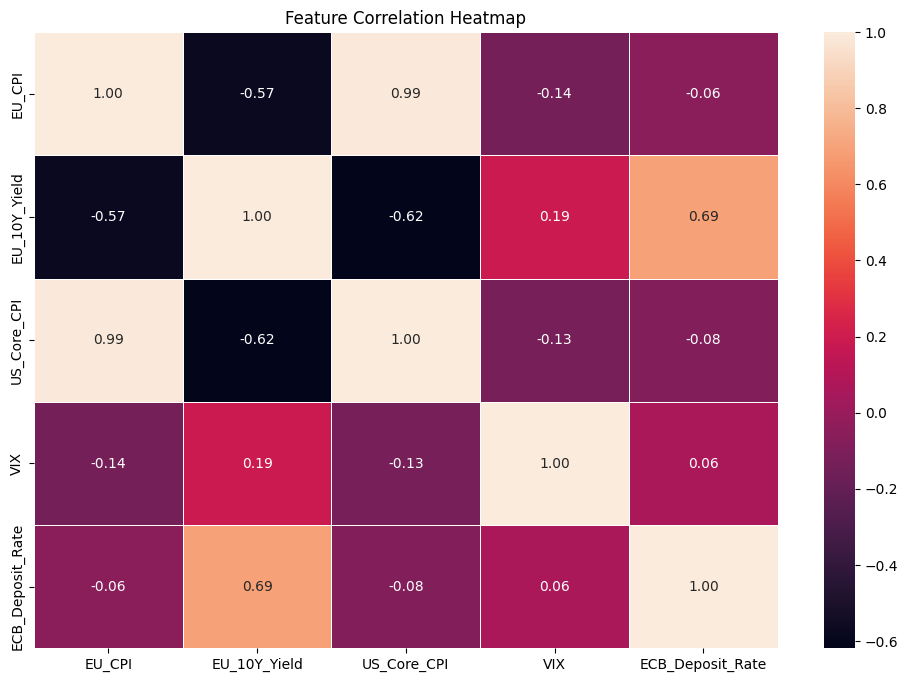

In [11]:
# Correlation Analysis
plt.figure(figsize=(12, 8))
corr_matrix = features[["EU_CPI", "EU_10Y_Yield", "US_Core_CPI", "VIX", "ECB_Deposit_Rate"]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
# Merge the labels and features dataframes on the index (Date)
merged_data = labels.to_frame(name='Target').join(features, how='inner')

# Display the merged dataframe
print(merged_data.head())

            Target  EU_CPI  EU_10Y_Yield  ECB_Deposit_Rate  US_CPI  \
Date                                                                 
2001-01-31       0   76.75      5.068026              3.75   174.6   
2001-02-28       0   76.43      5.008206              3.75   175.6   
2001-03-31       0   76.66      5.021069              3.75   176.0   
2001-04-30       1   77.07      4.938122              3.75   176.1   
2001-05-31       0   77.54      5.101378              3.50   176.4   

            US_Core_CPI  Fed_Funds_Rate  US_10Y_Yield    VIX  EU_CPI_lag_1  \
Date                                                                         
2001-01-31        183.3            6.40          5.19  22.02         76.46   
2001-02-28        183.9            5.98          4.92  28.35         76.75   
2001-03-31        184.4            5.49          4.93  28.64         76.43   
2001-04-30        184.7            5.31          5.35  25.48         76.66   
2001-05-31        185.1            4.80  

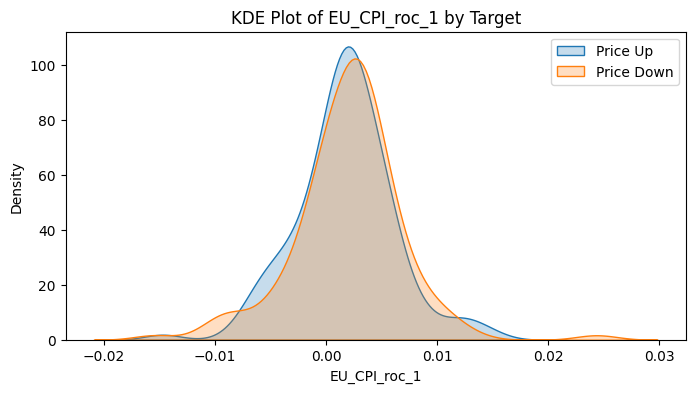

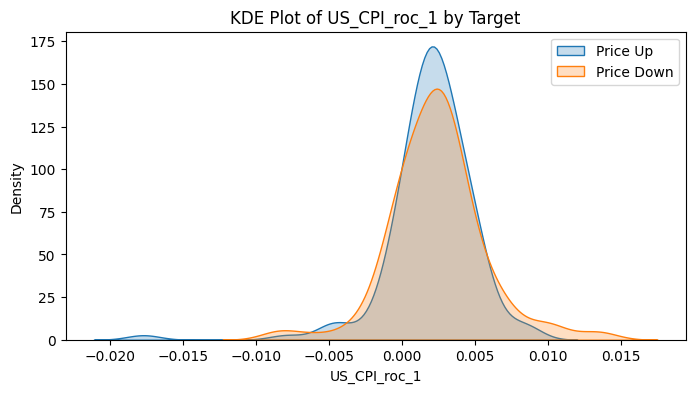

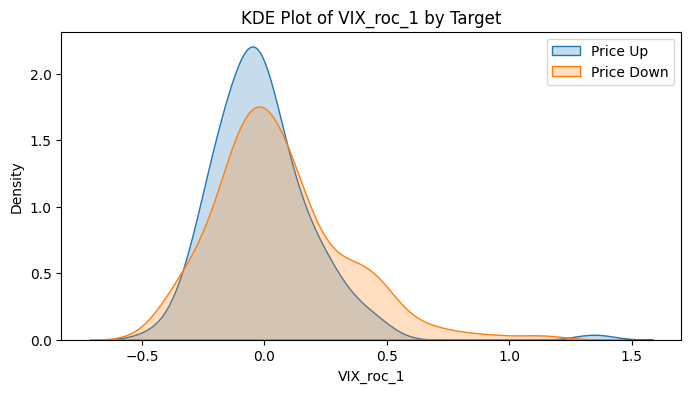

In [15]:
selected_features = ["EU_CPI_roc_1", "US_CPI_roc_1", "VIX_roc_1"]
for feature in selected_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(merged_data[merged_data['Target'] == 1][feature], label='Price Up', fill=True)
    sns.kdeplot(merged_data[merged_data['Target'] == 0][feature], label='Price Down', fill=True)
    plt.title(f"KDE Plot of {feature} by Target")
    plt.legend()
    plt.show()

[LightGBM] [Info] Number of positive: 103, number of negative: 103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5612
[LightGBM] [Info] Number of data points in the train set: 206, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

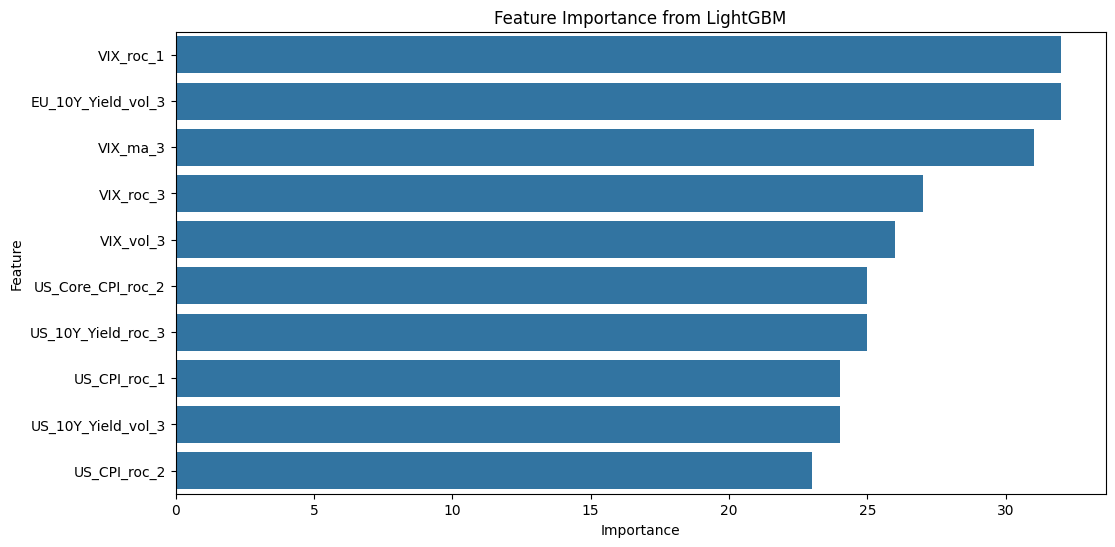

In [30]:
# Feature Importance using LightGBM
X = merged_data.drop(columns=["Target"])
y = merged_data["Target"]
# Split the data into training and testing sets based on time
split_date = "2020-01-01"
X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Feature Importance from LightGBM")
plt.show()

In [32]:
# Model Performance
preds = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.74      0.64        31
           1       0.60      0.40      0.48        30

    accuracy                           0.57        61
   macro avg       0.58      0.57      0.56        61
weighted avg       0.58      0.57      0.56        61



# Classification Report Explanation

The classification report shows the performance of our LGBM model in predicting EUR/USD price direction (up or down). Let's break down each metric:

## Precision
- **Definition**: Precision = TP / (TP + FP) - The ability of the model to avoid false positives
- **Class 0 (Price Down)**: The percentage of instances predicted as "price down" that were actually down
- **Class 1 (Price Up)**: The percentage of instances predicted as "price up" that were actually up

## Recall (Sensitivity)
- **Definition**: Recall = TP / (TP + FN) - The ability of the model to find all positive instances
- **Class 0**: The percentage of actual "price down" instances that were correctly predicted
- **Class 1**: The percentage of actual "price up" instances that were correctly predicted

## F1-Score
- **Definition**: F1 = 2 * (Precision * Recall) / (Precision + Recall) - The harmonic mean of precision and recall
- A balanced measure when classes are imbalanced

## Support
- The number of actual occurrences of each class in the test set

## Accuracy
- The overall percentage of correct predictions across both classes

## Macro Avg
- The unweighted mean of metrics for each class (treats both classes equally regardless of support)

## Weighted Avg
- The weighted mean of metrics for each class (accounts for class imbalance)

## Trading Implications
- **Precision for Class 1**: High precision for upward movements means we can be confident when the model predicts an upward move
- **Recall for Class 1**: High recall for upward movements means the model captures most of the upward price movements
- **Balance**: In trading, we often prefer higher precision over recall to reduce false signals

## Model Assessment
Based on this classification report, we can evaluate:
1. If our model is biased toward one class
2. If the model performs better for up or down movements
3. How reliable trading signals based on this model would be
4. Areas for improvement (e.g., feature engineering, different algorithms, hyperparameter tuning)

# Next Steps

Based on our exploratory data analysis and modeling results, here are potential next steps:

1. **Feature Selection**: Focus on the top features identified in the feature importance plot
   - The rate of change features (especially for VIX, US CPI, and EU CPI) seem particularly important

2. **Model Improvement**:
   - Try different algorithms (Random Forest, Neural Networks, XGBoost)
   - Implement hyperparameter tuning
   - Consider ensemble methods

3. **Trading Strategy Development**:
   - Create a simple trading strategy based on model predictions
   - Backtest the strategy with transaction costs
   - Implement risk management rules

4. **Advanced Feature Engineering**:
   - Create interaction terms between economic indicators
   - Add technical indicators from price data
   - Consider sentiment analysis from central bank communications

5. **Cross-Validation**:
   - Implement time-series cross-validation for more robust evaluation
   - Evaluate model stability across different market regimes

6. **Out-of-Sample Testing**:
   - Set aside the most recent data for final validation
   - Consider forward-testing with paper trading